In [36]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\PC\Data\ads_fraud_detection


In [37]:
save_dir=f"{exps_dir}/exp_prj_credit_card_transactions_fraud/exp_smote"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [38]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [39]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [40]:
x_train=pd.read_csv(f'{save_dir}/x_train.csv')
y_train=pd.read_csv(f'{save_dir}/y_train.csv')
x_test=pd.read_csv(f'{save_dir}/x_test.csv')
y_test=pd.read_csv(f'{save_dir}/y_test.csv')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5026242828782551, 1: 95.76412037037036}

In [41]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(611291, 2) (1241103, 2)


In [42]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(611291, 2)


In [43]:
x_test.shape

(611291, 21)

In [44]:
x_train.shape

(1241103, 21)

In [45]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [46]:
print(x_train.shape[1])

21


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [47]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [48]:


learning_rate=0.0001
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
# model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     kernel_regularizer=l2(0.01), **tabnet_params)
# model.compile(loss = 'categorical_crossentropy', optimizer = )
# model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy',,f1_score])
early_stopping = EarlyStopping(monitor='val_loss',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, save_format='tf')


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)


In [49]:
y_train_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [50]:
class_weights_dict

{0: 0.5026242828782551, 1: 95.76412037037036}

In [51]:
x_train

,amt,gender,city_pop,age,trans_month,trans_year,latitudinal_distance,longitudinal_distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,-0.000093,0,-0.293456,0.620236,4,1,-0.426654,-0.446743,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.077031,1,0.089542,-1.090464,7,1,0.862002,1.717500,0,0,0,0,0,0,1,0,0,0,0,0,0
2,-0.044826,1,-0.226449,-1.381506,7,0,0.775399,-1.014640,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0.337968,1,-0.278547,-0.512469,7,0,1.381621,0.145394,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.962903,1,-0.287644,0.239836,7,1,0.584872,0.443194,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241098,0.121706,1,-0.292431,1.061205,8,1,0.775399,1.250024,0,0,0,0,0,1,0,0,0,0,0,0,0
1241099,-0.392441,1,0.769301,-1.036660,11,0,1.007496,-0.242438,0,0,0,0,0,0,0,0,0,1,0,0,0
1241100,0.834208,0,-0.283132,-0.923862,7,1,-0.873526,-0.803410,0,0,0,1,0,0,0,0,0,0,0,0,0
1241101,0.026228,1,-0.292100,-0.938493,2,0,-1.649491,-0.000043,0,0,0,0,1,0,0,0,0,0,0,0,0


In [52]:
model.fit(x=x_train,y=y_train_onehot,
          validation_data=(x_test,y_test_onehot),
          batch_size=64,epochs= 1200, callbacks=[early_stopping,lr_scheduler])


Epoch 1/1200
19393/19393 [==============================] - 308s 14ms/step - loss: 0.0433 - accuracy: 0.9886 - f1_score: 0.5008 - val_loss: 0.0728 - val_accuracy: 0.9936 - val_f1_score: 0.5432 - lr: 1.0000e-04
Epoch 2/1200
19393/19393 [==============================] - 279s 14ms/step - loss: 0.0234 - accuracy: 0.9948 - f1_score: 0.5096 - val_loss: 0.1284 - val_accuracy: 0.9919 - val_f1_score: 0.5524 - lr: 1.0000e-04
Epoch 3/1200
19393/19393 [==============================] - 258s 13ms/step - loss: 0.0215 - accuracy: 0.9949 - f1_score: 0.5169 - val_loss: 0.0351 - val_accuracy: 0.9940 - val_f1_score: 0.5126 - lr: 1.0000e-04
Epoch 4/1200
19393/19393 [==============================] - 291s 15ms/step - loss: 0.0203 - accuracy: 0.9951 - f1_score: 0.5218 - val_loss: 0.0371 - val_accuracy: 0.9921 - val_f1_score: 0.5100 - lr: 1.0000e-04
Epoch 5/1200
19393/19393 [==============================] - 284s 15ms/step - loss: 0.0195 - accuracy: 0.9952 - f1_score: 0.5283 - val_loss: 0.0278 - val_accurac

In [53]:
model.summary()

Model: "tab_net_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder_2 (TabNetE  multiple                  25216     
 ncoder)                                                         
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 25248 (98.62 KB)
Trainable params: 23032 (89.97 KB)
Non-trainable params: 2216 (8.66 KB)
_________________________________________________________________


#### * Kết quả đánh giá mô hình:

In [54]:
model.summary()

Model: "tab_net_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder_2 (TabNetE  multiple                  25216     
 ncoder)                                                         
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 25248 (98.62 KB)
Trainable params: 23032 (89.97 KB)
Non-trainable params: 2216 (8.66 KB)
_________________________________________________________________


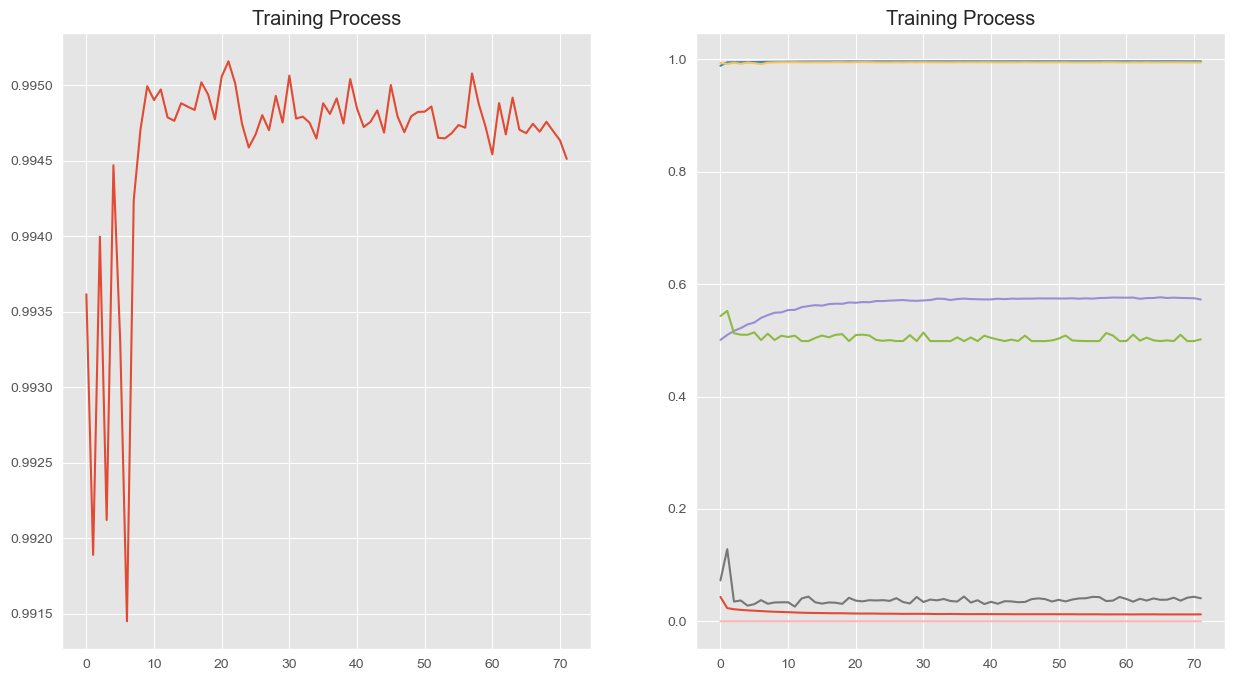

<Figure size 640x480 with 0 Axes>

In [55]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [56]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


19103/19103 [==============================] - 15s 781us/step


0.9949729343307852

In [57]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.9949729343307852
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    608120
           1       0.66      0.06      0.12      3171

    accuracy                           0.99    611291
   macro avg       0.83      0.53      0.56    611291
weighted avg       0.99      0.99      0.99    611291

Confusion Matrix:
[[608017    103]
 [  2970    201]]


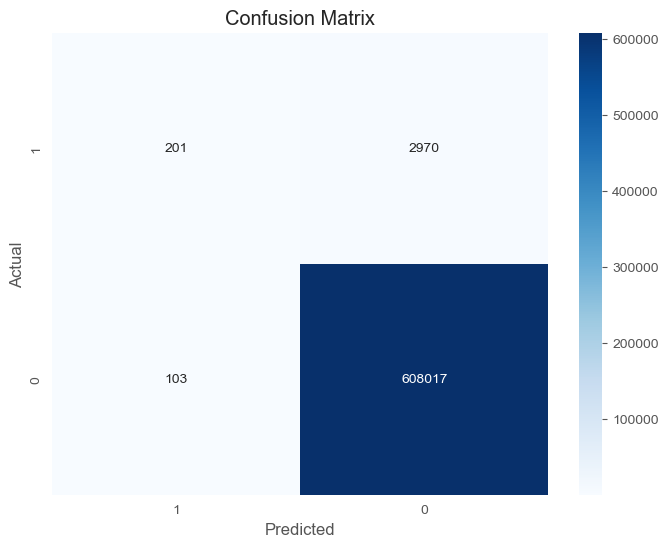

In [58]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

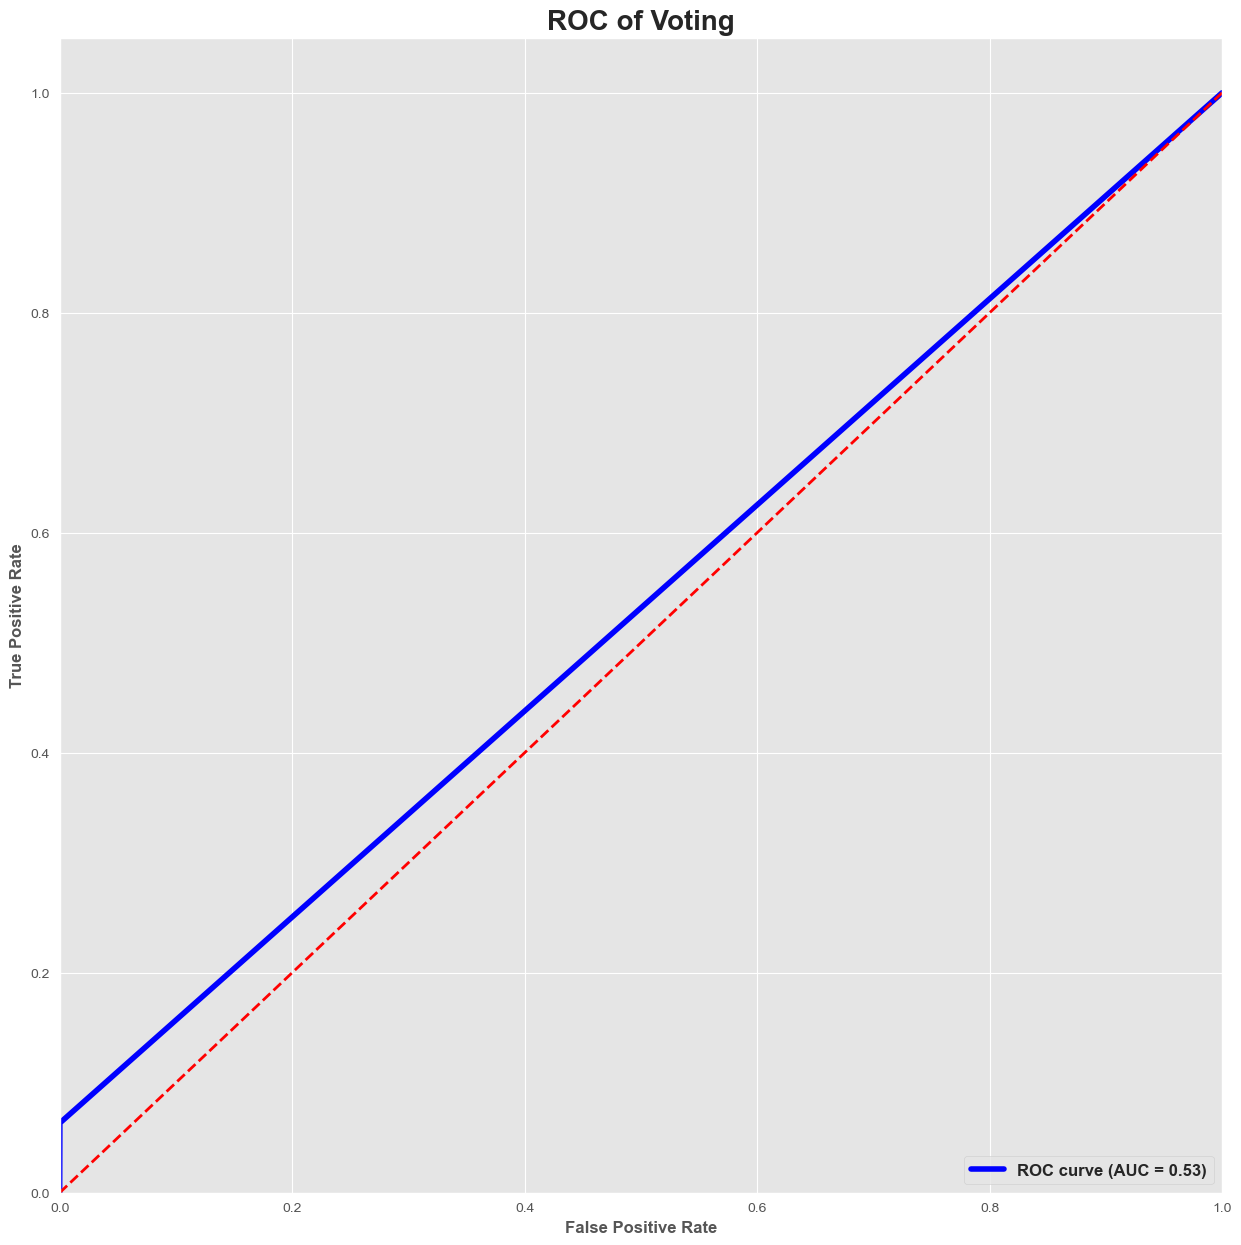

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [60]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [61]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    

In [62]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


NameError: name 'solandung' is not defined